## RESNET ARCHITECTURE

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils import model_to_dot

from time import time
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2.13.0


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'DATASET/TRAIN',target_size=(224,224),
                                     batch_size=32,class_mode='categorical')

Found 2000 images belonging to 10 classes.


In [5]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = 'DATASET/TEST',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 2000 images belonging to 10 classes.


In [6]:
def resnet(input_shape, n_classes):
  
  def conv_bn_rl(x, f, k=1, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
  
  
  def identity_block(tensor, f):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, tensor])
    output = ReLU()(x)
    return output
  
  
  def conv_block(tensor, f, s):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3, s)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(4*f, 1, strides=s)(tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    output = ReLU()(x)
    return output
  
  
  def resnet_block(x, f, r, s=2):
    x = conv_block(x, f, s)
    for _ in range(r-1):
      x = identity_block(x, f)
    return x
    
  
  input = Input(input_shape)
  
  x = conv_bn_rl(input, 64, 7, 2)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = resnet_block(x, 64, 3, 1)
  x = resnet_block(x, 128, 4)
  x = resnet_block(x, 256, 6)
  x = resnet_block(x, 512, 3)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision()])
  return model
     

input_shape = 224, 224, 3
n_classes = 10

K.clear_session()
model = resnet(input_shape, n_classes)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [7]:
model_path = "RESNET.h5"

from keras.callbacks import ModelCheckpoint

M = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, save_best_only=True)

In [8]:
epochs = 100
batch_size = 64

In [9]:
#### Fitting the model
history = model.fit(
           train_data, steps_per_epoch=train_data.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_data,validation_steps=test_data.samples // batch_size,
           callbacks=[M])

Epoch 1/100
31/31 [==============================] - ETA: 0s - loss: 3.0301 - accuracy: 0.1492 - precision: 0.1628
Epoch 1: accuracy improved from -inf to 0.14919, saving model to MOBILENET.h5
31/31 [==============================] - 249s 8s/step - loss: 3.0301 - accuracy: 0.1492 - precision: 0.1628 - val_loss: 158.5874 - val_accuracy: 0.0927 - val_precision: 0.0927
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 2.3205 - accuracy: 0.2188 - precision: 0.3276
Epoch 2: accuracy improved from 0.14919 to 0.21875, saving model to MOBILENET.h5
31/31 [==============================] - 260s 8s/step - loss: 2.3205 - accuracy: 0.2188 - precision: 0.3276 - val_loss: 2.4908 - val_accuracy: 0.1038 - val_precision: 0.0000e+00
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 2.2228 - accuracy: 0.2540 - precision: 0.3239
Epoch 3: accuracy improved from 0.21875 to 0.25403, saving model to MOBILENET.h5
31/31 [==============================] - 266s 9s/step - loss:

In [10]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

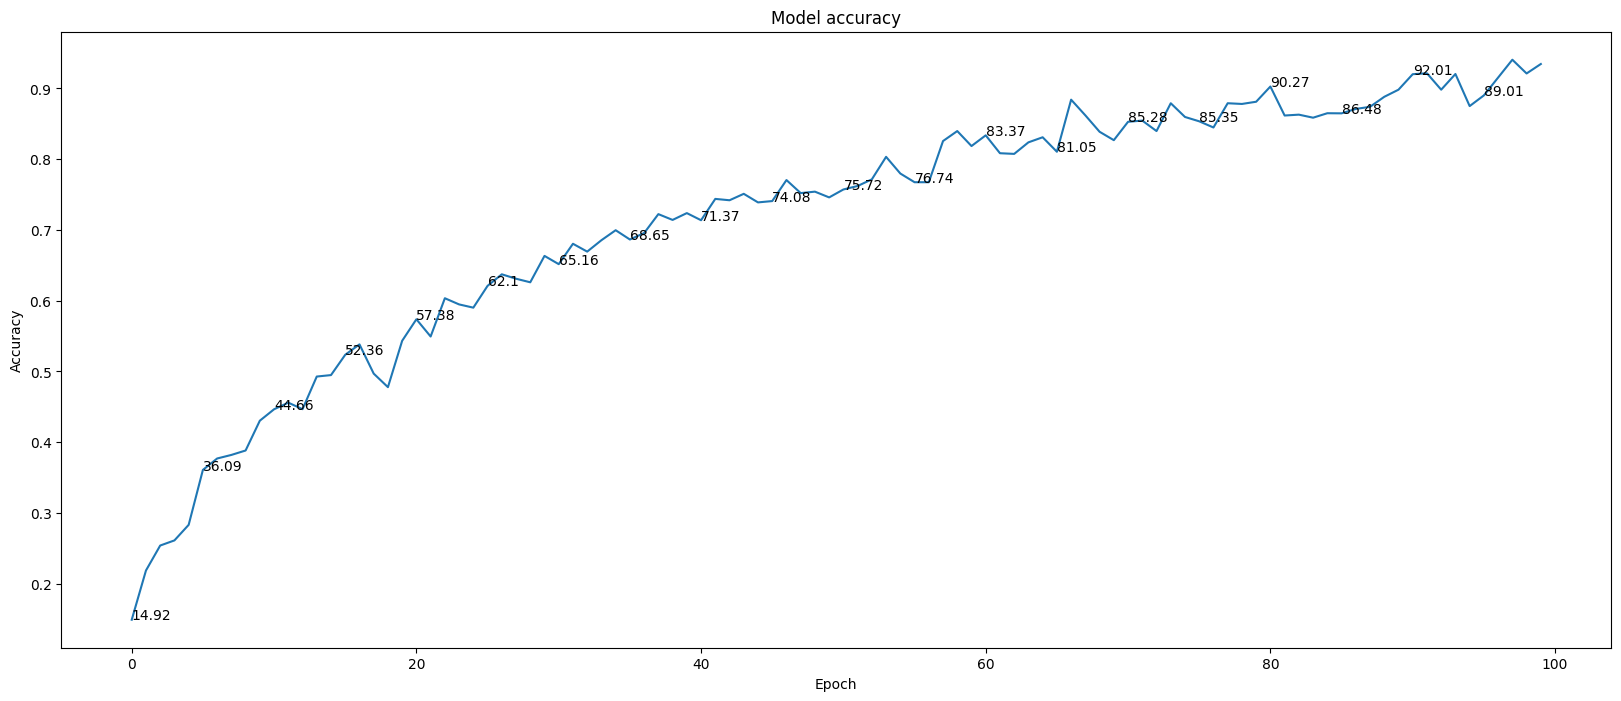

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

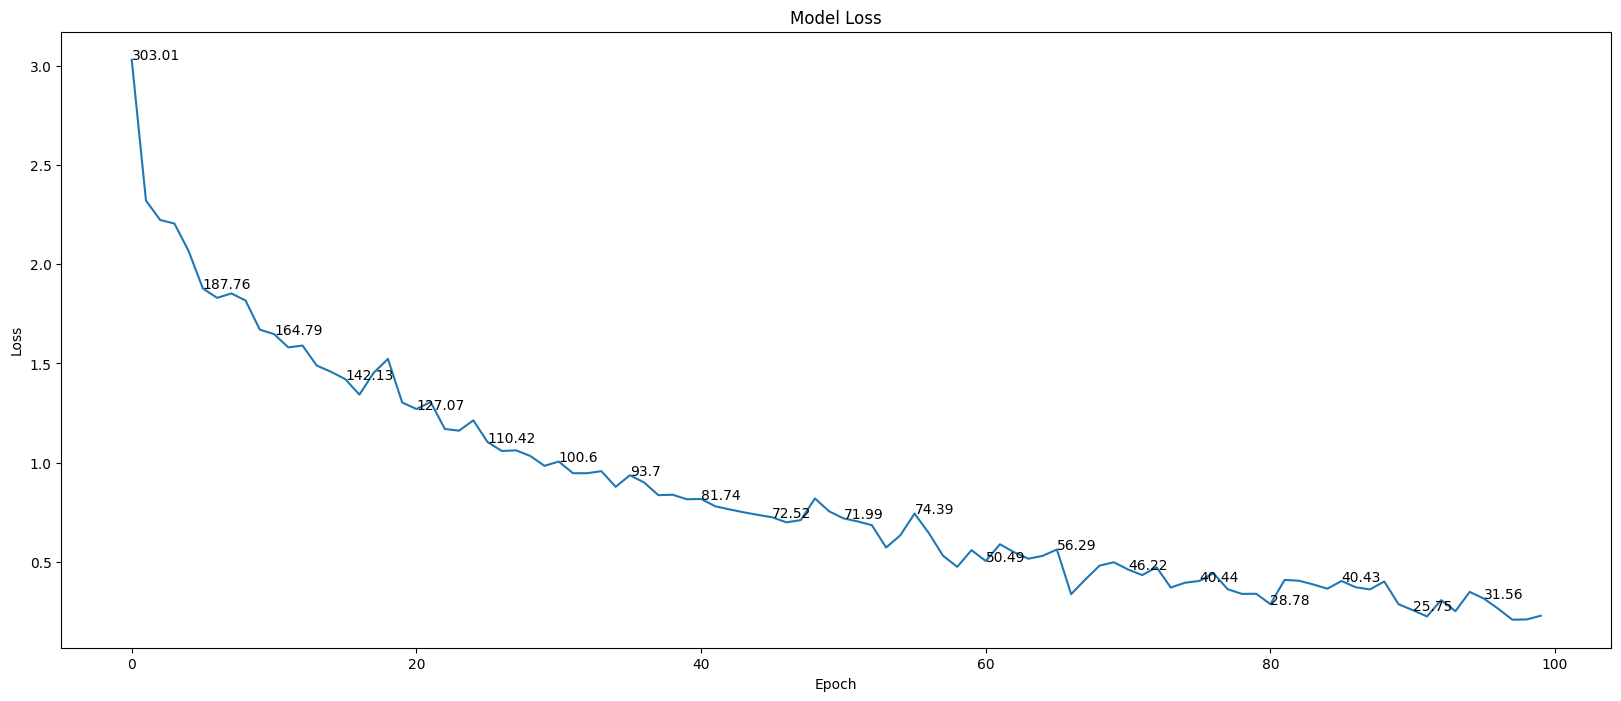

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()